In [32]:
# Install dependencies.
!pip install xgboost==1.2
!pip install imbalanced-learn==0.9.1
!pip install lime
!pip install shap
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Import required libraries

In [33]:
# Import required dependencies
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from datetime import datetime

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

from xgboost import XGBClassifier
import xgboost as xgb_lib

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import sklearn

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
 
from collections import Counter
import shap
from sklearn.model_selection import StratifiedKFold

from io import StringIO

# ----------------
import sklearn.datasets
import sklearn.ensemble
import lime
import lime.lime_tabular
from __future__ import print_function

# Allow pandas to display all columns from a dataframe
pd.options.display.max_columns = None



# !pip install plotly
from plotly import graph_objects as go


# 2. Read data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
# Readind data
df = pd.read_csv('/content/drive/MyDrive/Maestria/modelo/data/all.csv')
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,porcentaje_adelanto,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices,RatioSumAmountOutstandingLateInvoice,AvgDaysLateOutstandingInvoicesBeingLate,PaidTime
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,90.0,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,140.0,49,1,0.020408,31836238.82,137688.20,0.004325,6.0,0,0,0.0,0.0,0.0,0.0,0.0,1
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,85.0,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,NaN,11.0,64.0,0,0,0.000000,0.00,0.00,0.000000,0.0,0,0,0.0,0.0,0.0,0.0,0.0,1
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,90.0,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza,60.0,147.0,0,0,0.000000,0.00,0.00,0.000000,0.0,0,0,0.0,0.0,0.0,0.0,0.0,1
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,85.0,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre,10.0,29.0,13,4,0.307692,24832580.74,6848070.24,0.275770,4.0,0,0,0.0,0.0,0.0,0.0,0.0,1
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,90.0,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,186.0,43,1,0.023256,17600606.68,137688.20,0.007823,6.0,8,0,0.0,4078948.6,0.0,0.0,0.0,1


In [35]:
df.drop([
    "cliente_sector","cliente_regimen_fiscal", "cliente_ocupacion", 
    "credito_fecha_inicio",	"credito_fecha_fin",	"fecha_pago",
    "pagador_rfc", "pagador_scian_nombre"
], axis=1, inplace=True)

# 3. Data Engineering

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24003 entries, 0 to 24002
Data columns (total 20 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   factura_importe                          24003 non-null  float64
 1   porcentaje_adelanto                      24003 non-null  float64
 2   linea_limite                             24003 non-null  float64
 3   cliente_edad                             24003 non-null  float64
 4   payment_term                             24003 non-null  float64
 5   NumberTotalPaidInvoices                  24003 non-null  int64  
 6   NumberInvoicesPaidLate                   24003 non-null  int64  
 7   RatioInvoicesPaidLate                    24003 non-null  float64
 8   SumAmountTotalPaidInvoices               24003 non-null  float64
 9   SumAmountInvoicesPaidLate                24003 non-null  float64
 10  RatioSumAmountInvoicesPaidLate           24003

1    12253
3     4493
2     4108
4     1976
5     1173
Name: PaidTime, dtype: int64


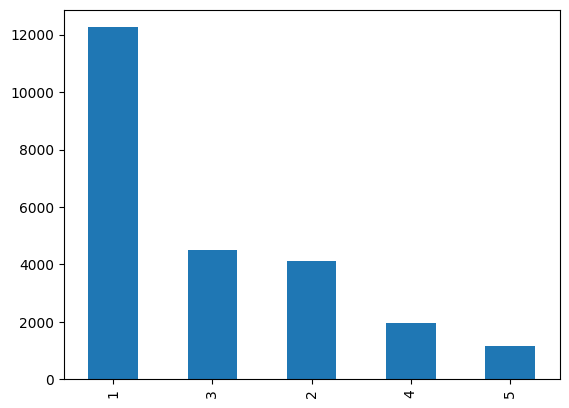

In [37]:
# Class classification
df['PaidTime'].value_counts().plot(kind='bar')
print(df['PaidTime'].value_counts())

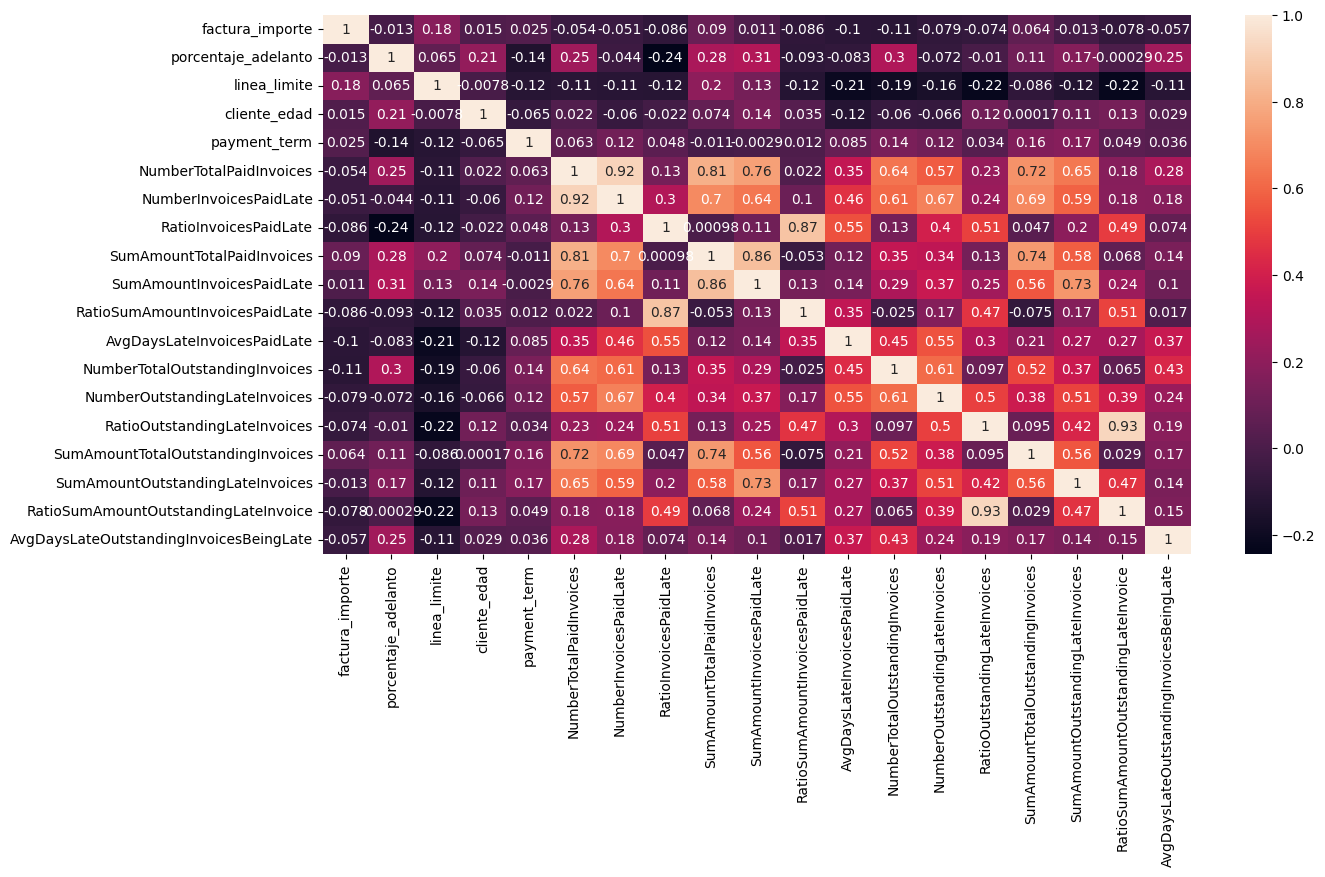

In [38]:
features_df = df.drop(['PaidTime'], axis=1)
corr_df = features_df.corr(method='pearson')
# print("The correlation DataFrame is:")
# print(corr_df, "\n")

plt.figure(figsize=(14, 7))
sns.heatmap(corr_df, annot=True)
plt.show()

# 4. Prepare dataframes for modeling approaches

## 4.1 Separate target for predictions

In [39]:
X = df.drop(['PaidTime'], axis=1)
y = df.PaidTime

In [40]:
print('X:', X.shape)
print('y:', y.shape)

X: (24003, 19)
y: (24003,)


In [41]:
# Break off validation set from training data set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
print('Trainging dataset shape: ', X_train.shape)
print('Test dataset shape: ', X_test.shape)

Trainging dataset shape:  (19202, 19)
Test dataset shape:  (4801, 19)


In [ ]:
# df_train, df_test = train_test_split(df, train_size=0.8)

# # Split dataset into train and test and save it into S3 bucket
# s3_res = boto3.Session().resource('s3')

# csv_buffer_train = StringIO()
# df_train.to_csv(csv_buffer_train, index=False)
# s3_res.Object(bucket_name, 'data/train.csv').put(Body=csv_buffer_train.getvalue())

# csv_buffer_test = StringIO()
# df_test.to_csv(csv_buffer_test, index=False)
# s3_res.Object(bucket_name, 'data/test.csv').put(Body=csv_buffer_test.getvalue())

# print("Dataframes are saved as CSV in S3 bucket.")

# 4. Helper functions

In [74]:
def tranform_confusion_matrix(confusion_matrix, targets_list=None):
    """
    function to transform confusion matrix to dataframe needed to plot Sankey chart
    
    returns a dataframe and list of unique labels for Sankey chart nodes
    
    Parameters
    --------------
    confusion_matrix : numpy.ndarray
        The confusion matrix to be visualised
    target_list : {'list', 'numpy.ndarray'}
        List of unique classes
        
    """
    
    # create a dataframe
    
    if targets_list is None:
        df = pd.DataFrame(data=confusion_matrix, 
                          index=[f"True Class-{i+1}" for i in range(confusion_matrix.shape[0])],
                          columns=[f"Predicted Class-{i+1}" for i in range(confusion_matrix.shape[0])])
    else:
        df = pd.DataFrame(data=confusion_matrix, 
                          index=[f"True {i}" for i in targets_list],
                          columns=[f"Predicted {i}" for i in targets_list])

    # restructre the dataframe
    df = df.stack().reset_index()

    # rename the default column names
    df.rename(columns={'level_0':'source', 'level_1':'target', 0:'value'}, inplace=True)

    # add new column for colour
    # here rgba(211,255,216,0.6) indicates green colour whereas rgba(245,173,168,0.6) is red colour
    # green colour illustrates correct predictions and red colour is for incorrect predictions
    df["colour"] = df.apply(lambda x: 
                              "rgba(211,255,216,0.6)" if x.source.split()[1:] == x.target.split()[1:] 
                               else "rgba(245,173,168,0.6)", axis=1)

    # extract unique values from source and target columns
    labels = pd.concat([df.source, df.target]).unique()

    # get indices of the above unique values
    labels_indices = {label:index for index, label in enumerate(labels)}
    labels_indices

    # map the source and target column using the above indices
    df[["source", "target"]] = df[["source", "target"]].applymap(lambda x: labels_indices[x])

    # create a column for tooltip
    df["tooltip"] = df.apply(lambda x:
                             f"{x['value']} {' '.join(labels[x['source']].split()[1:])} instances correctly classified as {' '.join(labels[x['target']].split()[1:])}" 
                             if x['colour']=='rgba(211,255,216,0.6)'

                             else 
                             f"{x['value']} {' '.join(labels[x['source']].split()[1:])} instances misclassified as {' '.join(labels[x['target']].split()[1:])}", axis=1)

    return df, labels
    

def plot_sankey_for_confusion_matrix(df, labels):
    
    """
    plots sankey diagram from given dataframe and labels
    """
    
    # plot figure
    fig = go.Figure(data=[go.Sankey(
    
    node = dict(
      pad = 20,
      thickness = 20,
      line = dict(color = "black", width = 1.0),
      label = labels,
      
      # this template will be used to display text when hovering over nodes  
      hovertemplate = "%{label} has total %{value:d} instances<extra></extra>"
    ),
    link = dict(
      source = df.source, 
      target = df.target,
      value = df.value,
      color = df.colour,
      customdata = df['tooltip'], 
        
      # this template will be used to display text when hovering over the links  
      hovertemplate = "%{customdata}<extra></extra>"  
    ))])

    fig.update_layout(title_text="Confusion Matrix Visualisation Using Sankey Diagram", font_size=13,
                      width=800, height=600)
    
    return fig


In [63]:
# Helper function to plot confusion matrix
def render_confusion_matrix(y_test_input, predicted, clasess):
    ac_s = accuracy_score(y_test_input, predicted) * 100
    print('The Accuracy is: ', ac_s, " %")

    cm = confusion_matrix(y_test_input, predicted, labels=clasess)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clasess)
    disp.plot()

    return ac_s

In [49]:
# Helper function to plot models accuracies
def plot_models_accuracy(models_name, accuracies):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(models_name,accuracies)
    _ = plt.xticks(rotation=90,fontsize=14)
    plt.title('Compare accuracy (test)')
    plt.ylim(70, 100)
    plt.show()   

# 5. Test models

## 5.1 Decision Tree Classifier

The Accuracy is:  79.42095396792335  %


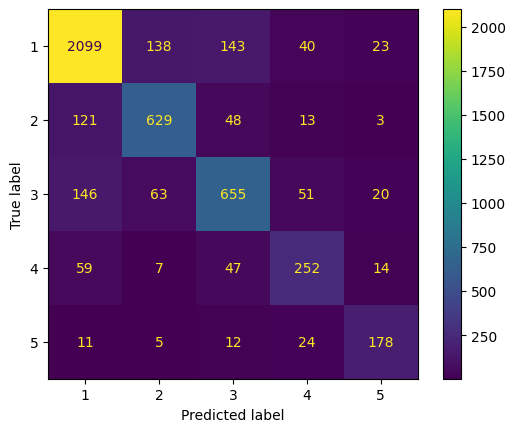

In [65]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

predicted_tree = tree.predict(X_test)

ac_dtc = render_confusion_matrix(y_test, predicted_tree, tree.classes_)

### 5.1.1 Shap values for Decision Tree Classifier

In [ ]:
# Fits the explainer
explainer = shap.Explainer(tree.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 3743it [02:12, 26.86it/s]                          


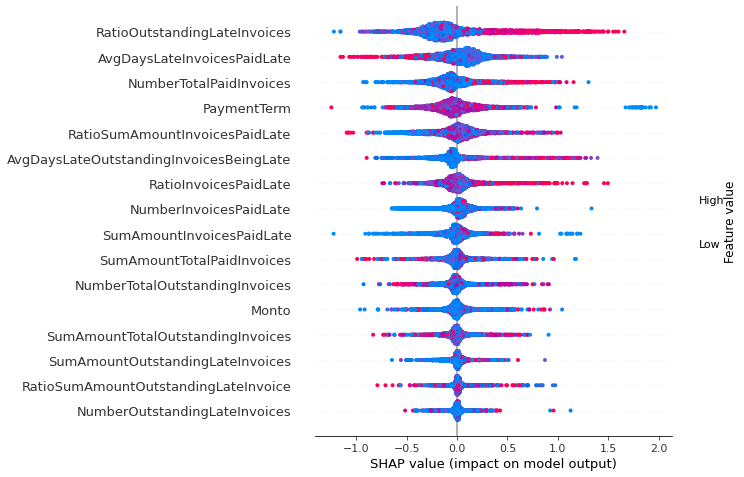

In [ ]:
shap.summary_plot(shap_values)

## 5.2 Random Forests Classifier

The Accuracy is:  83.0868569048115  %


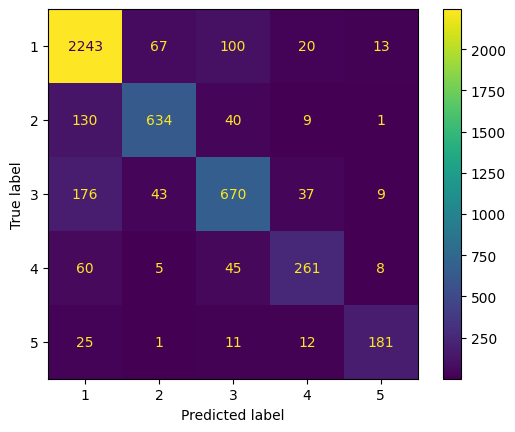

In [66]:
#Create a Gaussian Classifier
rf_clf=RandomForestClassifier(n_estimators=200, random_state=0)

# Attach feature names to the model 
rf_clf.feature_names_ = list(X_train.columns.values)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf_clf.fit(X_train, y_train)

predicted_rf=rf_clf.predict(X_test)

ac_rfc = render_confusion_matrix(y_test, predicted_rf, rf_clf.classes_)

In [76]:
cm = confusion_matrix(y_test, predicted_rf, labels=rf_clf.classes_)
df,labels = tranform_confusion_matrix(cm, ['Before time','In time','1-7 days late','8-21 days late','More than 21 days late']) 
plot_sankey_for_confusion_matrix(df, labels)


In [ ]:
importances = rf_clf.feature_importances_

# Summarize feature importance    
forest_importances = pd.Series(importances, index=X_train.columns.values)
forest_importances.sort_values(ascending=False)

payment_term                               0.106033
factura_importe                            0.098116
SumAmountTotalPaidInvoices                 0.068047
NumberTotalPaidInvoices                    0.066226
RatioInvoicesPaidLate                      0.060908
RatioSumAmountInvoicesPaidLate             0.060772
linea_limite                               0.060484
cliente_edad                               0.054886
SumAmountTotalOutstandingInvoices          0.051880
NumberTotalOutstandingInvoices             0.048870
RatioOutstandingLateInvoices               0.045898
RatioSumAmountOutstandingLateInvoice       0.044852
NumberInvoicesPaidLate                     0.044806
SumAmountInvoicesPaidLate                  0.044553
AvgDaysLateOutstandingInvoicesBeingLate    0.034431
NumberOutstandingLateInvoices              0.034272
SumAmountOutstandingLateInvoices           0.032734
AvgDaysLateInvoicesPaidLate                0.032646
porcentaje_adelanto                        0.009586
dtype: float

### 5.2.1 Testing the models on new clients

Total of new clients: 203
The Accuracy is:  69.45812807881774  %


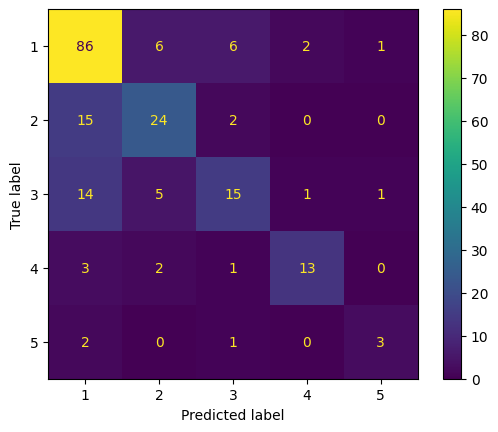

In [ ]:
# Test results for new clients
# Filter new clients from testing dataset
df_new_clients_X = X_test[X_test['NumberTotalPaidInvoices'] == 0]
print('Total of new clients:', len(df_new_clients_X))

df_new_clients_y = y_test.filter(items=df_new_clients_X.index, axis=0)

predicted_rf_new_clients=rf_clf.predict(df_new_clients_X)
ac_rfc_new_clients = render_confusion_matrix(df_new_clients_y, predicted_rf_new_clients, rf_clf.classes_)

# Modeling approach for new clients

In [ ]:
df_new_clients = df[df['NumberTotalPaidInvoices'] == 0].copy()
df_new_clients.shape

(1144, 20)

In [ ]:
# Remove catagorical features
df_new_clients.drop([
    "NumberTotalPaidInvoices","NumberInvoicesPaidLate","RatioInvoicesPaidLate","SumAmountTotalPaidInvoices",
    "SumAmountInvoicesPaidLate","RatioSumAmountInvoicesPaidLate","AvgDaysLateInvoicesPaidLate","NumberTotalOutstandingInvoices","NumberOutstandingLateInvoices",
    "RatioOutstandingLateInvoices","SumAmountTotalOutstandingInvoices","SumAmountOutstandingLateInvoices","RatioSumAmountOutstandingLateInvoice",
    "AvgDaysLateOutstandingInvoicesBeingLate"
], axis=1, inplace=True)

df_new_clients.head()

,factura_importe,porcentaje_adelanto,linea_limite,cliente_edad,payment_term,PaidTime
1,5486110.96,85.0,375000.0,11.0,64.0,1
2,5464161.79,90.0,20000000.0,60.0,147.0,1
8,3411891.84,85.0,200000.0,10.0,14.0,1
11,3100835.60,85.0,577573.1,27.0,98.0,1
14,2757185.49,85.0,9000000.0,10.0,32.0,1


Trainging dataset shape:  (800, 5)
Test dataset shape:  (344, 5)
The Accuracy is:  69.47674418604652  %
Feature importance:
 factura_importe        0.346139
porcentaje_adelanto    0.019575
linea_limite           0.181608
cliente_edad           0.156331
payment_term           0.296346
dtype: float64


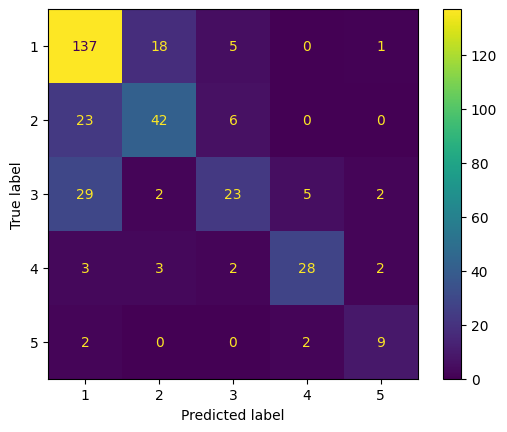

In [ ]:
X_new_clients = df_new_clients.drop(['PaidTime'], axis=1)
y_new_clients = df_new_clients.PaidTime


# Break off validation set from training data set
X_train_new_clients, X_test_new_clients, y_train_new_clients, y_test_new_clients = train_test_split(X_new_clients, y_new_clients, train_size=0.7, test_size=0.3, random_state=0)
print('Trainging dataset shape: ', X_train_new_clients.shape)
print('Test dataset shape: ', X_test_new_clients.shape)

#Create a Gaussian Classifier
rf_clf_new_clients=RandomForestClassifier(n_estimators=200, random_state=0)

# Attach feature names to the model 
rf_clf_new_clients.feature_names_ = list(X_train_new_clients.columns.values)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf_clf_new_clients.fit(X_train_new_clients, y_train_new_clients)

predicted_rf_new_clients=rf_clf_new_clients.predict(X_test_new_clients)

ac_rfc_new_clients = render_confusion_matrix(y_test_new_clients, predicted_rf_new_clients, rf_clf_new_clients.classes_)

importances = rf_clf_new_clients.feature_importances_

# Summarize feature importance    
forest_importances = pd.Series(importances, index=rf_clf_new_clients.feature_names_)
forest_importances.sort_values(ascending=False)
print('Feature importance:\n', forest_importances)

### 5.2.2 Explaining predictions with LIME

#### Create the explainer

In [ ]:
target_names = np.array(['before time', 'on time', '1-7 days late', '8-21 days late', 'More than 21 days late'])
# target_names = np.array([1, 2, 4, 5, 3])

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=target_names,
    mode='classification'
)

#### Explaining an instance

Since this is a multi-class classification problem, we set the top_labels parameter, so that we only explain the top class.

In [ ]:
i = np.random.randint(0, X_test.shape[0])

In [ ]:
testing_row = X_test.iloc[i]

# We now explain a single instance
lime_instance_expl = lime_explainer.explain_instance(
    data_row=testing_row, 
    predict_fn=rf_clf.predict_proba,
    num_features=6,
    top_labels=1
)

# Representing the explanation
lime_instance_expl.show_in_notebook(show_table=True, show_all=False)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [ ]:
lime_instance_expl.predict_proba

array([0.905, 0.015, 0.015, 0.04 , 0.025])

### 5.2.3 Explaining predictions with Shap values

In [ ]:
# Fits the explainer
shap_explainer = shap.TreeExplainer(rf_clf)
# Calculates the SHAP values - It takes some time
# shap_values_rfc = shap_explainer(X_test)
shap_values_rfc = shap_explainer.shap_values(X_train)

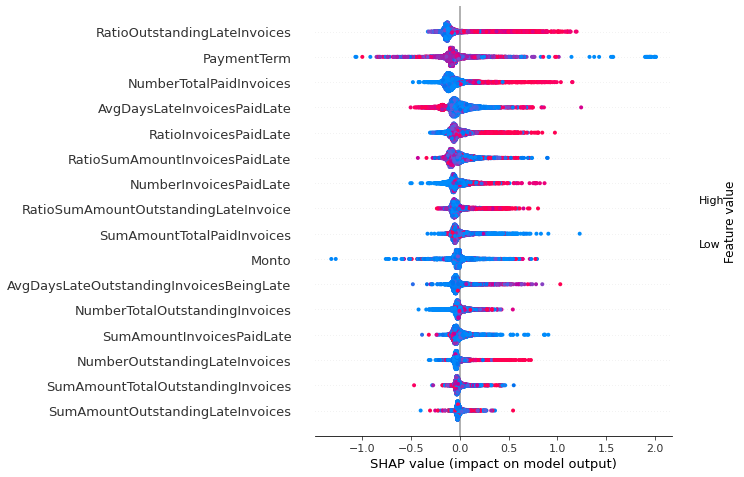

In [ ]:
shap.summary_plot(shap_values_rfc)

## 5.3 XGBoost Classifier

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


The Accuracy is:  80.27494272026661  %


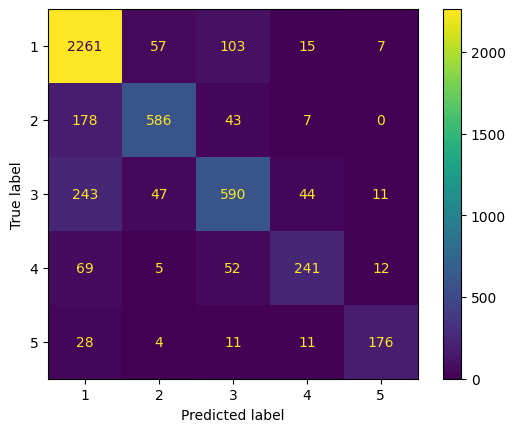

In [ ]:
xgb = XGBClassifier()

xgb.fit(X_train, y_train)

predicted_xgb = xgb.predict(X_test)

ac_xgbc = render_confusion_matrix(y_test, predicted_xgb, xgb.classes_)

### 5.3.1 Shap values for XGBoost Classifier

In [ ]:
# Fits the explainer
explainer = shap.Explainer(xgb.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values_xgb = explainer(X_test)

Permutation explainer: 3743it [1:01:08,  1.02it/s]                          


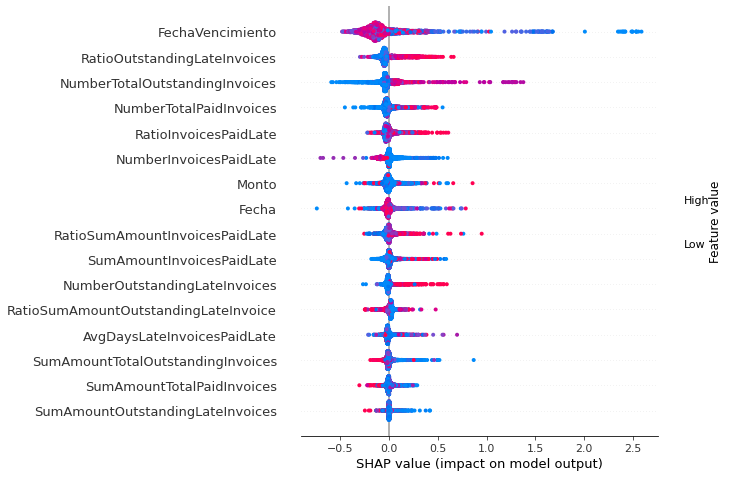

In [ ]:
shap.summary_plot(shap_values_xgb)

# 6. Models comparison

## 6.1 Models accuracies

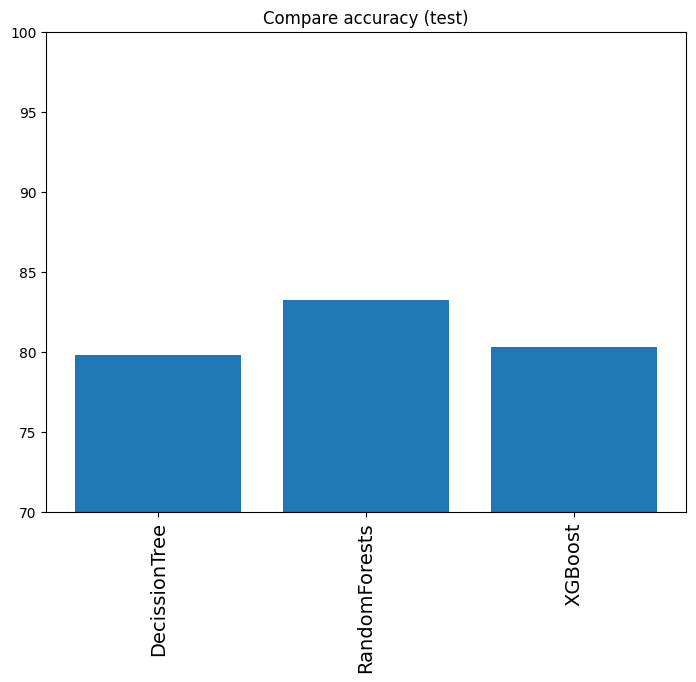

[79.7750468652364, 83.23265986252864, 80.27494272026661]


In [ ]:
# Models accuracies
accuracies = [ac_dtc, ac_rfc, ac_xgbc]
models_name = ['DecissionTree', 'RandomForests', 'XGBoost']
plot_models_accuracy(models_name, accuracies)
print(accuracies)

## 6.2 Running a cross validation

In [ ]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
scores_tree = cross_val_score(tree, X, y, cv=cv, scoring='f1_macro')
print(scores_tree)
print('-----------------')
scores_rf = cross_val_score(rf_clf, X, y, cv=cv, scoring='f1_macro')

print('-----------------')
scores_xgb = cross_val_score(xgb, X, y, cv=cv, scoring='f1_macro')

[0.73108659 0.73537781 0.72075433 0.7319186  0.73662175 0.73039705
 0.71809327 0.73866618 0.74462523 0.73055283 0.72923413 0.72861939
 0.73861573 0.71494856 0.72742288 0.73547303 0.73608404 0.73495144
 0.72344866 0.7330303  0.7252156  0.745952   0.74069694 0.73055111
 0.73938195 0.72999976 0.73636084 0.73674847 0.73373709 0.7339654 ]
-----------------
-----------------


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

In [ ]:
print('Decision tree',scores_tree)
print('Random forest',scores_rf)
print('XGBoost',scores_xgb)

Decision tree [0.73108659 0.73537781 0.72075433 0.7319186  0.73662175 0.73039705
 0.71809327 0.73866618 0.74462523 0.73055283 0.72923413 0.72861939
 0.73861573 0.71494856 0.72742288 0.73547303 0.73608404 0.73495144
 0.72344866 0.7330303  0.7252156  0.745952   0.74069694 0.73055111
 0.73938195 0.72999976 0.73636084 0.73674847 0.73373709 0.7339654 ]
Random forest [0.7842562  0.7889974  0.78126438 0.78552802 0.78075746 0.78667698
 0.77739288 0.77940652 0.79250019 0.79238353 0.78139381 0.77775904
 0.7860287  0.78004134 0.78561692 0.79086164 0.78510038 0.77938564
 0.78519696 0.79057124 0.78135133 0.7931961  0.78885495 0.77789825
 0.79159366 0.78130822 0.78697181 0.78255246 0.78771176 0.7855112 ]
XGBoost [0.75714528 0.7485326  0.74198198 0.75218288 0.74876063 0.75618099
 0.73669525 0.7499454  0.75624233 0.75647471 0.74596769 0.75451104
 0.75512622 0.74457225 0.74554064 0.74640919 0.75375503 0.75636568
 0.74049771 0.74389615 0.74266195 0.75975538 0.75111055 0.74755745
 0.75499391 0.75107419 0

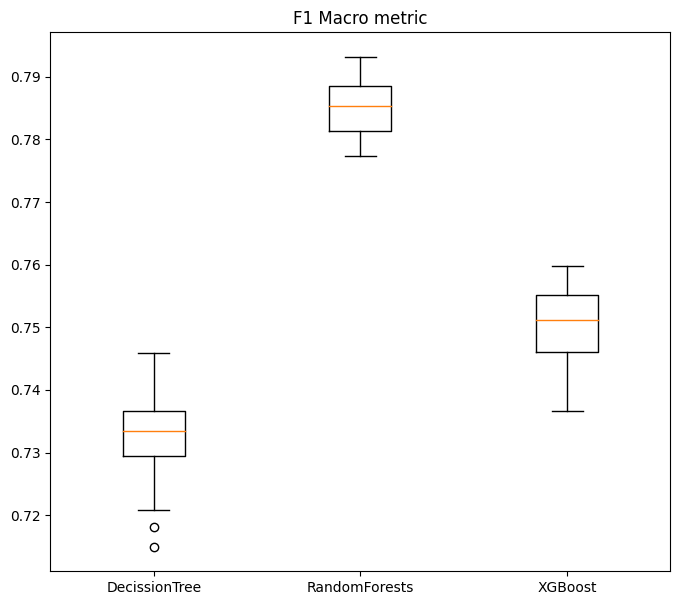

In [ ]:
# Boxplots after running 30 times
fig = plt.figure(figsize =(8, 7))
 
# Creating plot
plt.boxplot([scores_tree, scores_rf, scores_xgb], labels=models_name)
plt.title("F1 Macro metric")

# show plot
plt.show()

In [ ]:
accuracies_tree = cross_val_score(tree, X, y, cv=cv, scoring='accuracy')
accuracies_rf = cross_val_score(rf_clf, X, y, cv=cv, scoring='accuracy')
accuracies_xgb = cross_val_score(xgb, X, y, cv=cv, scoring='accuracy')

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

In [ ]:
print('Decision tree',accuracies_tree)
print('Random forest',accuracies_rf)
print('XGBoost',accuracies_xgb)

Decision tree [0.77850299 0.78003055 0.77280933 0.78544647 0.78322455 0.77822525
 0.76781003 0.78739064 0.78405777 0.77836412 0.78100264 0.78266907
 0.78600194 0.7683655  0.77155951 0.77766977 0.7807249  0.78114151
 0.77725316 0.78155812 0.7775309  0.7857242  0.79238995 0.77919733
 0.78989029 0.77711429 0.78516873 0.77419803 0.7857242  0.77905846]
Random forest [0.82335787 0.82571865 0.82377448 0.82738509 0.82071934 0.82280239
 0.82058047 0.82377448 0.82655187 0.82766282 0.82266352 0.81946952
 0.82571865 0.8218303  0.82071934 0.82557978 0.82432995 0.82030274
 0.82530204 0.82557978 0.82419108 0.83030135 0.82891265 0.82099708
 0.83169004 0.82224691 0.82682961 0.82030274 0.82780169 0.82266352]
XGBoost [0.79655603 0.79377864 0.79252882 0.79711151 0.79405638 0.79961117
 0.78808499 0.79877795 0.79697264 0.79836134 0.79572282 0.79961117
 0.80099986 0.79252882 0.79086238 0.79280655 0.79475073 0.79725038
 0.78947368 0.78975142 0.79238995 0.80308291 0.79822247 0.79516734
 0.80349951 0.79544508 0

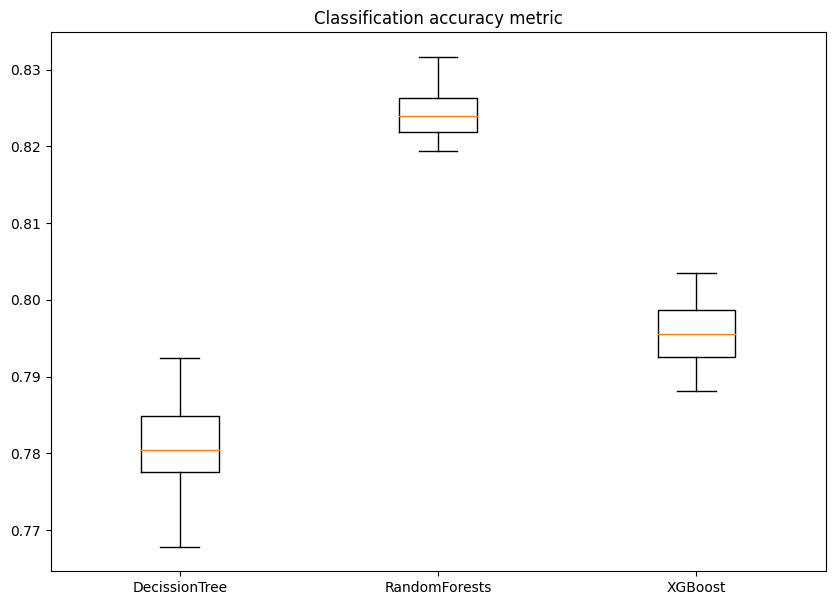

In [ ]:
# Boxplots after running 30 times
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot([accuracies_tree, accuracies_rf, accuracies_xgb], labels=models_name)
plt.title("Classification accuracy metric")

# show plot
plt.show()

# 7. Working with Invoice level features only

In [ ]:
# X_invoice_level_features = df.loc[:, ['factura_importe', 'payment_term', 'linea_limite']]
X_invoice_level_features = df.loc[:, ['factura_importe', 'payment_term']]
X_invoice_level_features.head()

,factura_importe,payment_term
0,6905230.58,140.0
1,5486110.96,64.0
2,5464161.79,147.0
3,5286577.84,29.0
4,5198617.84,186.0


In [ ]:
# Break off validation set from training data set
X_train, X_test, y_train, y_test = train_test_split(X_invoice_level_features, y, train_size=0.8, test_size=0.2, random_state=0)
print('Trainging dataset shape: ', X_train.shape)
print('Test dataset shape: ', X_test.shape)

Trainging dataset shape:  (19202, 2)
Test dataset shape:  (4801, 2)


The Accuracy is:  49.218912726515306  %


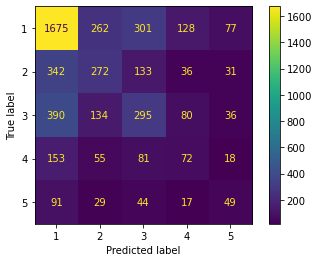

In [ ]:
#Create a Gaussian Classifier
rf_clf_invoice_level = RandomForestClassifier(n_estimators=200, random_state=0)

#Attach feature names to the model 
rf_clf_invoice_level.feature_names_ = list(X_train.columns.values)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf_clf_invoice_level.fit(X_train, y_train)

predicted_rf_invoice_level = rf_clf_invoice_level.predict(X_test)

ac_rfc_invoice_level = render_confusion_matrix(y_test, predicted_rf_invoice_level, rf_clf_invoice_level.classes_)

# 8. Working with Invoice + Customer level features

In [ ]:
X_invoice_customer_level_features = df.loc[:, ['factura_importe', 'linea_limite', 'cliente_regimen_fiscal', 'cliente_sector', 'cliente_edad', 'payment_term',]]
X_invoice_customer_level_features.head()

,factura_importe,linea_limite,cliente_regimen_fiscal,cliente_sector,cliente_edad,payment_term
0,6905230.58,20000000.0,0,0,60.0,140.0
1,5486110.96,375000.0,0,0,11.0,64.0
2,5464161.79,20000000.0,0,0,60.0,147.0
3,5286577.84,9000000.0,0,0,10.0,29.0
4,5198617.84,20000000.0,0,0,60.0,186.0


In [ ]:
# Break off validation set from training data set
X_train, X_test, y_train, y_test = train_test_split(X_invoice_customer_level_features, y, train_size=0.8, test_size=0.2, random_state=0)
print('Trainging dataset shape: ', X_train.shape)
print('Test dataset shape: ', X_test.shape)

Trainging dataset shape:  (19202, 6)
Test dataset shape:  (4801, 6)


The Accuracy is:  60.15413455530098  %


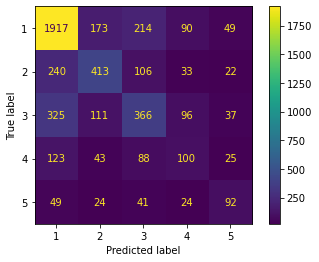

In [ ]:
#Create a Gaussian Classifier
rf_clf_invoice_customer_level = RandomForestClassifier(n_estimators=200, random_state=0)

#Attach feature names to the model 
rf_clf_invoice_customer_level.feature_names_ = list(X_train.columns.values)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf_clf_invoice_customer_level.fit(X_train, y_train)

predicted_rf_invoice_level = rf_clf_invoice_customer_level.predict(X_test)

ac_rfc_invoice_level = render_confusion_matrix(y_test, predicted_rf_invoice_level, rf_clf_invoice_customer_level.classes_)

# 9. Save the selected model

In [ ]:
import joblib

model_name = 'model.joblib'
with open(model_name, 'wb') as f:
    joblib.dump(rf_clf, f)

print("Model was saved.")

with open('model.joblib', 'rb') as f:
    predictor = joblib.load(f)

df_predict = X_test.iloc[0:1]

print('Prediction:', predictor.predict(df_predict))

Model was saved.
Prediction: [3]


# 10. Model Deployment Script

In [ ]:
import json
import os
import joblib
import pickle
import tarfile
import sagemaker
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role
import time
from time import gmtime, strftime
import subprocess

In [ ]:
#Setup
client = boto3.client(service_name="sagemaker")
runtime = boto3.client(service_name="sagemaker-runtime")
boto_session = boto3.session.Session()

s3_resource = boto3.Session().resource('s3')
region = boto_session.region_name
print(region)
sagemaker_session = sagemaker.Session()

role = get_execution_role()
print(role)

us-west-2
arn:aws:iam::244210425001:role/service-role/AmazonSageMaker-ExecutionRole-20220610T101490


In [ ]:
bashCommand = "tar -cvpzf model.tar.gz model.joblib inference.py"
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

In [ ]:
#Upload tar.gz to bucket
model_artifacts = f"s3://{bucket_name}/output/multiclass-clasification/model/model.tar.gz"

response = s3_resource.meta.client.upload_file('model.tar.gz', bucket_name, 'output/multiclass-clasification/model/model.tar.gz')
# TODO Remove model.joblib and model.tar.gz if they will no longer needed

In [ ]:
region = boto3.Session().region_name

# Retrieve sklearn image
image_uri = sagemaker.image_uris.retrieve(
    framework="sklearn",
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type="ml.m5.xlarge",
)

In [ ]:
#Step 1: Model Creation
model_name = "sklearn-test" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name: " + model_name)
create_model_response = client.create_model(
    ModelName=model_name,
    Containers=[
        {
            "Image": image_uri,
            "Mode": "SingleModel",
            "ModelDataUrl": model_artifacts,
            "Environment": {'SAGEMAKER_SUBMIT_DIRECTORY': model_artifacts,
                           'SAGEMAKER_PROGRAM': 'inference.py'} 
        }
    ],
    ExecutionRoleArn=role,
)

print("Model Arn: " + create_model_response["ModelArn"])

Model name: sklearn-test2022-10-31-18-30-30
Model Arn: arn:aws:sagemaker:us-west-2:244210425001:model/sklearn-test2022-10-31-18-30-30


In [ ]:
#Step 2: EPC Creation
sklearn_epc_name = "sklearn-epc" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=sklearn_epc_name,
    ProductionVariants=[
        {
            "VariantName": "sklearnvariant",
            "ModelName": model_name,
            "InstanceType": "ml.c5.large",
            "InitialInstanceCount": 1
        },
    ],
)

print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

Endpoint Configuration Arn: arn:aws:sagemaker:us-west-2:244210425001:endpoint-config/sklearn-epc2022-10-31-18-30-34


In [ ]:
#Step 3: EP Creation
endpoint_name = "sklearn-local-ep" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=sklearn_epc_name,
)
print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

#Monitor creation
describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)
print(describe_endpoint_response)

Endpoint Arn: arn:aws:sagemaker:us-west-2:244210425001:endpoint/sklearn-local-ep2022-10-31-18-30-39
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService
{'EndpointName': 'sklearn-local-ep2022-10-31-18-30-39', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:244210425001:endpoint/sklearn-local-ep2022-10-31-18-30-39', 'EndpointConfigName': 'sklearn-epc2022-10-31-18-30-34', 'ProductionVariants': [{'VariantName': 'sklearnvariant', 'DeployedImages': [{'SpecifiedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-scikit-learn:1.0-1-cpu-py3', 'ResolvedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-scikit-learn@sha256:e7887de688db0abeb4ae7f0467d18c69c613d3795bc23c425ec0574b19b81350', 'ResolutionTime': datetime.datetime(2022, 10, 31, 18, 30, 41, 60000, tzinfo=tzlocal())}], 'CurrentWeight': 1.0, 'DesiredWeight': 1.0, 'CurrentInstanceCount': 1, 'DesiredInstanceCount': 1}], 'EndpointStatus': 'InService', 'CreationTime': datetime.datetim

# 11. Model invocation

In [ ]:
row = X_test.iloc[0:1]
# row = [200.0,2018.0,37400.0,445,17,50,12874467.33,206333.52,0.016027,103.0,49,1,0.020408,5,4,0.00144]
row = row.values[0].tolist()
print(row)

[37400.0, 65.0, 445.0, 17.0, 0.038202247191011236, 12874467.33, 206333.52000000002, 0.016026567524017325, 100.3529411764706, 49.0, 1.0, 0.02040816326530612, 2423289.33, 3489.28, 0.001439894096343832, 103.0]


In [ ]:
import boto3
import json
print(endpoint_name)
# endpoint_name = 'sklearn-local-ep2022-10-10-15-53-04'
runtime_client = boto3.client('sagemaker-runtime')
content_type = "application/json"
# request_body = {"Input": [[0.09178, 0.0, 4.05, 0.0, 0.51, 6.416, 84.1, 2.6463, 5.0, 296.0, 16.6, 395.5, 9.04]]}

request_body = {"Input": [row]}

data = json.loads(json.dumps(request_body))
payload = json.dumps(data)

response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType=content_type,
    Body=payload)
result = json.loads(response['Body'].read().decode())
print(result['Output'])

sklearn-local-ep2022-10-31-18-30-39
[1]


# Clean up
## Deleting the endpoint
Once that we're donde predicting, we can delete the endpoint (and stop paying for it). We can re-deploy again by running the appropiate cell above.

In [ ]:
sagemaker.Session().delete_endpoint(endpoint_name=endpoint_name)
sagemaker.Session().delete_endpoint_config(sklearn_epc_name)